<a href="https://colab.research.google.com/github/Jinyoung9393/AIFFEL_ONLINE_QUEST/blob/master/Main_Quest/mainquest03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**데이터 불러오기 + Resize 하기**

In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import glob
import os

def resize_images(img_path):
    images = glob.glob(img_path + "/*.jpg")

    print(len(images), " images to be resized.")

    # 이미지 크기를 128x128로 변경하여 저장합니다.
    target_size = (128, 128)
    for img in images:
        old_img = Image.open(img)
        new_img = old_img.resize(target_size, Image.ANTIALIAS)
        new_img.save(img, "JPEG")

    print(len(images), " images resized.")
## 가위, 바위, 보 이미지들이 있는 디렉토리 경로를 설정합니다.
image_dir_path = "/content/drive/MyDrive/rock scissor paper/train/scissor/"
resize_images(image_dir_path)
image_dir_path = "/content/drive/MyDrive/rock scissor paper/train/rock/"
resize_images(image_dir_path)
image_dir_path = "/content/drive/MyDrive/rock scissor paper/train/paper/"
resize_images(image_dir_path)


100  images to be resized.


<ipython-input-5-0b4f5435e1b3>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [6]:
def load_data(img_path, number_of_data=300):
    # 이미지 크기와 컬러 채널 설정
    img_size=128
    color=3
    # 이미지 데이터와 라벨을 담을 배열 초기화
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    # "scissor" 폴더에 있는 이미지들을 불러와 데이터와 라벨을 할당
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=0
        idx=idx+1
    # "rock" 폴더에 있는 이미지들을 불러와 데이터와 라벨을 할당
    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1
        idx=idx+1
    # "paper" 폴더에 있는 이미지들을 불러와 데이터와 라벨을 할당
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2
        idx=idx+1


    return imgs, labels
# 데이터가 있는 디렉토리 경로를 설정하고 load_data 함수를 사용하여 학습에 사용될 데이터 준비
image_dir_path ="/content/drive/MyDrive/rock scissor paper/train"
(x_train, y_train)=load_data(image_dir_path)
# 이미지 데이터를 0과 1 사이의 값으로 정규화
x_train_norm = x_train/255.0
# 데이터의 형태 출력
print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

x_train shape: (300, 128, 128, 3)
y_train shape: (300,)


라벨:  0


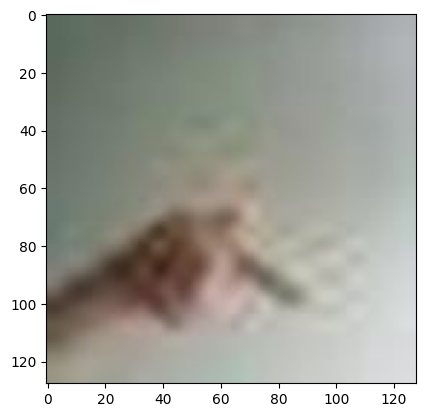

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

**딥러닝 네트워크 설계하기**

In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=12

# Sequential 모델 생성
model=keras.models.Sequential()

# 첫 번째 Convolutional 레이어 추가
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128,128,3)))

# 첫 번째 MaxPooling 레이어 추가
model.add(keras.layers.MaxPool2D(2,2))

# 두 번째 Convolutional 레이어 추가
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))

# 두 번째 MaxPooling 레이어 추가
model.add(keras.layers.MaxPooling2D((2,2)))

# 평탄화 (Flatten) 레이어 추가
model.add(keras.layers.Flatten())

# Fully Connected 레이어 추가
model.add(keras.layers.Dense(32, activation='relu'))

# 출력 레이어 추가 (3개의 클래스로 분류하므로 노드 개수는 3, softmax 활성화 함수 사용)
model.add(keras.layers.Dense(3, activation='softmax'))

# Model에 추가된 Layer 개수 출력
print('Model에 추가된 Layer 개수: ', len(model.layers))

# Model의 구조를 요약하여 출력
model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (No

### 딥러닝 네트워크 학습시키기

In [9]:
# 모델 컴파일
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
#에폭 12로 설정
model.fit(x_train, y_train, epochs=12)

Epoch 1/12
10/10 [==============================] - 5s 357ms/step - loss: 261.3655 - accuracy: 0.3433
Epoch 2/12
10/10 [==============================] - 4s 349ms/step - loss: 1.2659 - accuracy: 0.3567
Epoch 3/12
10/10 [==============================] - 4s 418ms/step - loss: 1.0835 - accuracy: 0.3333
Epoch 4/12
10/10 [==============================] - 5s 490ms/step - loss: 1.0807 - accuracy: 0.4000
Epoch 5/12
10/10 [==============================] - 4s 349ms/step - loss: 0.9383 - accuracy: 0.5300
Epoch 6/12
10/10 [==============================] - 3s 342ms/step - loss: 0.3960 - accuracy: 0.8800
Epoch 7/12
10/10 [==============================] - 5s 560ms/step - loss: 0.0566 - accuracy: 0.9867
Epoch 8/12
10/10 [==============================] - 4s 352ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 9/12
10/10 [==============================] - 4s 387ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 10/12
10/10 [==============================] - 5s 455ms/step - loss: 5.8222e-04 - accuracy: 

In [10]:
# 테스트용 디렉토리에 있는 "paper" 폴더의 이미지들을 resize
image_dir_path_test = "/content/drive/MyDrive/rock scissor paper/test/paper"
resize_images(image_dir_path_test)

# 테스트용 디렉토리에 있는 "rock" 폴더의 이미지들을 resize
image_dir_path_test = "/content/drive/MyDrive/rock scissor paper/test/rock"
resize_images(image_dir_path_test)

# 테스트용 디렉토리에 있는 "scissor" 폴더의 이미지들을 resize
image_dir_path_test = "/content/drive/MyDrive/rock scissor paper/test/scissor"
resize_images(image_dir_path_test)

100  images to be resized.


<ipython-input-5-0b4f5435e1b3>:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  new_img = old_img.resize(target_size, Image.ANTIALIAS)


100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [11]:
# 테스트용 이미지들이 있는 디렉토리 경로
image_dir_path_test ="/content/drive/MyDrive/rock scissor paper/test"
# 로드한 이미지 데이터와 라벨 데이터를 각각 x_test와 y_test에 할당
(x_test, y_test)=load_data(image_dir_path_test)
# 255로 나누어 이미지 데이터를 0~1 사이로 스케일링하여 정규화함
x_test_norm = x_test/255.0

In [12]:
# x_test의 형태를 출력함
print("x_test shape: {}".format(x_test.shape))
# y_test의 형태를 출력함
print("y_test shape: {}".format(y_test.shape))

x_test shape: (300, 128, 128, 3)
y_test shape: (300,)


### **테스트**

In [13]:
# 모델을 테스트 데이터로 평가하여 테스트 손실(test_loss)과 테스트 정확도(test_accuracy)를 얻음
# x_test: 테스트용 이미지 데이터
# y_test: 테스트용 이미지에 대한 라벨 데이터
# verbose=2: 평가 과정의 진행 상태를 출력하지 않도록 설정
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)

# 모델을 사용하여 테스트 데이터에 대한 예측 결과를 얻음.
# x_test: 테스트용 이미지 데이터를 입력으로 모델에 넣고 예측 결과를 얻음
predicted_result = model.predict(x_test)

# 모델의 예측 결과에서 가장 높은 확률을 가진 클래스의 인덱스를 얻음.
# predicted_result: 모델의 예측 결과 (각 클래스에 대한 확률값으로 구성된 배열)
# np.argmax: 배열에서 가장 큰 값의 인덱스를 반환하는 함수를 사용하여 예측된 라벨 값을 얻음
predicted_labels = np.argmax(predicted_result, axis=1)

10/10 - 1s - loss: 3.8871 - accuracy: 0.6633 - 1s/epoch - 127ms/step
10/10 [==============================] - 2s 193ms/step


**시각화하기**

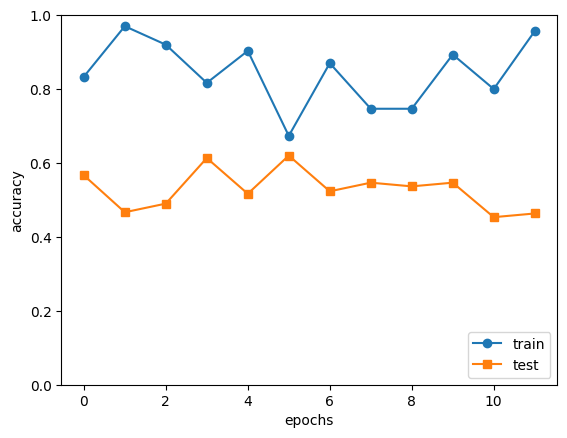

In [14]:
train_accuracy = []
test_accuracy = []

for epoch in range(n_train_epoch):
    # 모델을 한 에폭동안 훈련
    model.fit(x_train_norm, y_train, epochs=1, verbose=0)

    # 훈련 데이터와 테스트 데이터에 대해 모델을 평가하여 정확도 저장
    train_loss, train_acc = model.evaluate(x_train_norm, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(x_test_norm, y_test, verbose=0)

    # 정확도 값을 리스트에 추가
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

# 훈련 및 테스트 데이터에 대한 정확도를 에폭별로 시각화
markers = {'train': 'o', 'test': 's'}
x = np.arange(n_train_epoch)

plt.plot(x, train_accuracy, marker='o', label='train', markevery=1)
plt.plot(x, test_accuracy, marker='s', label='test', markevery=1)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()